# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

## Загрузка и подготовка данных

In [2]:
reg0 = pd.read_csv('/datasets/geo_data_0.csv')
reg1 = pd.read_csv('/datasets/geo_data_1.csv')
reg2 = pd.read_csv('/datasets/geo_data_2.csv')
print(reg0.info())
print(reg1.info())
print(reg2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory 

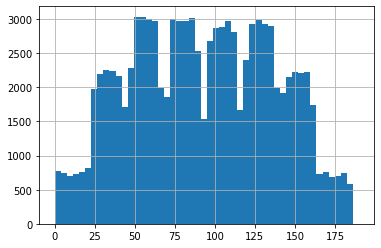

In [3]:
reg0['product'].hist(bins=50,range=[0,190])

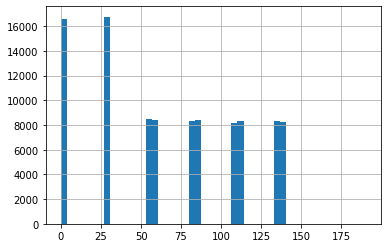

In [4]:
reg1['product'].hist(bins=50,range=[0,190])

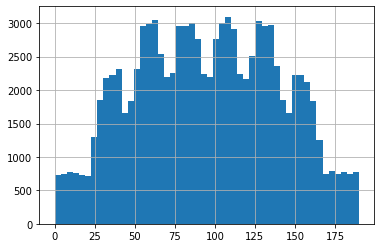

In [5]:
reg2['product'].hist(bins=50,range=[0,190])

Удаляем ненужный признак

In [6]:
reg0 = reg0.drop('id', axis=1)
reg1 = reg1.drop('id', axis=1)
reg2 = reg2.drop('id', axis=1)

In [7]:
print(reg0[reg0['product'] == 0]['product'].value_counts())
print(reg1[reg1['product'] == 0]['product'].value_counts())
print(reg2[reg2['product'] == 0]['product'].value_counts())

0.0    1
Name: product, dtype: int64
0.0    8235
Name: product, dtype: int64
0.0    1
Name: product, dtype: int64


In [8]:
# reg0 = reg0[reg0['product'] != 0]
# reg1 = reg1[reg1['product'] != 0]
# reg2 = reg2[reg2['product'] != 0]

### Вывод 1:

Данные второго региона весьма непохожи на данные первого и третьего, что странно. Данные первого и третьего регионов похожи на нормальное распределение. Данные второго региона равномерно собраны по группам в 8000 примерно одинаковых значений. Возможно стоит отправить их на перепроверку.

## Обучение и проверка модели

### Разделение данных

In [9]:
def split(reg):
    re_X = reg.drop('product', axis=1)
    re_y = reg['product']
    reg_X_train,reg_X_test,reg_y_train,reg_y_test = train_test_split(re_X,re_y,test_size=0.25)
    print(reg_X_train.shape,reg_y_train.shape,reg_X_test.shape,reg_y_test.shape)
    return reg_X_train, reg_y_train, reg_X_test, reg_y_test

In [10]:
reg0_X_train,reg0_y_train,reg0_X_test,reg0_y_test = split(reg0)
reg1_X_train,reg1_y_train,reg1_X_test,reg1_y_test = split(reg1)
reg2_X_train,reg2_y_train,reg2_X_test,reg2_y_test = split(reg2)

(75000, 3) (75000,) (25000, 3) (25000,)
(75000, 3) (75000,) (25000, 3) (25000,)
(75000, 3) (75000,) (25000, 3) (25000,)


### Линейная регрессия

In [11]:
def LR(f_train,t_train,f_test,t_test):
    
    scaler = MinMaxScaler()
    f_train = scaler.fit_transform(f_train)
    f_test = scaler.transform(f_test)
    
    model = LinearRegression()
    model.fit(f_train,t_train)
    prediction = model.predict(f_test)
    prediction = pd.Series(prediction)
    rmse = (mean_squared_error(t_test,prediction)**0.5)
    mid_prod = sum(prediction) / len(prediction)
    test = t_test.reset_index(drop=True)
    return prediction, test, rmse, mid_prod

### Обучение моделей

In [12]:
prediction0, test0, rmse0, mid0 = LR(reg0_X_train,reg0_y_train,reg0_X_test,reg0_y_test)
prediction1, test1, rmse1, mid1 = LR(reg1_X_train,reg1_y_train,reg1_X_test,reg1_y_test)
prediction2, test2, rmse2, mid2 = LR(reg2_X_train,reg2_y_train,reg2_X_test,reg2_y_test)

In [13]:
print(' RMSE 0:  {0:.2f}'.format(rmse0),'Средний обьем в скважине: {0:.2f}\n'.format(mid0),
      'RMSE 1:  {0:.2f}'.format(rmse1),'Средний обьем в скважине: {0:.2f}\n'.format(mid1),
      'RMSE 2:  {0:.2f}'.format(rmse2),'Средний обьем в скважине: {0:.2f}\n'.format(mid2))

 RMSE 0:  37.77 Средний обьем в скважине: 92.49
 RMSE 1:  0.89 Средний обьем в скважине: 68.79
 RMSE 2:  39.93 Средний обьем в скважине: 95.01



### Вывод 2:

Обучены модели, подозрительно хорошо обучилась модель второго региона, причина видимо в странных данных. Определен средний обьем баррелей в скважине.

## Подготовка к расчёту прибыли

In [14]:
budget = 10000000000
barrel = 450000
cp = 200
p = 500

In [15]:
n = budget/barrel
print('Минимум баррелей нужно добыть: {0:.0f} тыс.'.format(n))

Минимум баррелей нужно добыть: 22222 тыс.


In [16]:
mid_min = n/cp
print('Минимальный средний уровень нефти в скважине: {0:.0f} тыс.'.format(mid_min))

Минимальный средний уровень нефти в скважине: 111 тыс.


In [17]:
print(' Средний обьем в скважине первого региона: {0:.2f} \n Разность между средней и точкой безубыточности: {1:.2f}\n\n'
      .format(mid0, mid0-mid_min),
      'Средний обьем в скважине второго региона: {0:.2f} \n Разность между средней и точкой безубыточности: {1:.2f}\n\n'
      .format(mid1, mid1-mid_min),
      'Средний обьем в скважине третьего региона: {0:.2f} \n Разность между средней и точкой безубыточности: {1:.2f}\n'
      .format(mid2, mid2-mid_min))

 Средний обьем в скважине первого региона: 92.49 
 Разность между средней и точкой безубыточности: -18.63

 Средний обьем в скважине второго региона: 68.79 
 Разность между средней и точкой безубыточности: -42.33

 Средний обьем в скважине третьего региона: 95.01 
 Разность между средней и точкой безубыточности: -16.10



### Вывод 3: 

Минимальный средний уровень выше чем то что мы имеем по всем регионам. С другой стороны скважин с запасами больше минимального среднего тоже достаточно.

In [18]:
def profit(target,prob):
    p_sorted = prob.sort_values(ascending=False)
    selected = target[p_sorted.index][:200]
    return barrel * selected.sum() - budget

## Расчёт прибыли и рисков 

In [19]:
def bootstrap(target, prob):

    state = np.random.RandomState(42)

    values = []
    for i in range(1000):
        target_subsample = target.sample(500, replace=True, random_state=state)
        probs_subsample = prob[target_subsample.index] 
        summ = profit(target_subsample,probs_subsample)
        values.append(summ)

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    risk = st.percentileofscore(values, 0)
    
    return mean, lower, upper, risk

In [20]:
mid_0, lower_0, upper_0, risk_0 = bootstrap(test0, prediction0)

In [21]:
print(' Средний доход в первом регионе: {0:.0f} руб.\n 95% доверительный интервал от {1:.2f} до {2:.2f} руб.\n Риск: {3:.1f}%'
      .format(mid_0, lower_0, upper_0, risk_0))

 Средний доход в первом регионе: 432060117 руб.
 95% доверительный интервал от -130107302.57 до 963232402.39 руб.
 Риск: 6.4%


In [22]:
mid_1, lower_1, upper_1, risk_1 = bootstrap(test1, prediction1)
print(' Средний доход в первом регионе: {0:.0f} руб.\n 95% доверительный интервал от {1:.2f} до {2:.2f} руб.\n Риск: {3:.1f}%'
      .format(mid_1, lower_1, upper_1, risk_1))

 Средний доход в первом регионе: 544717312 руб.
 95% доверительный интервал от 128754559.74 до 965091961.27 руб.
 Риск: 0.7%


In [23]:
mid_2, lower_2, upper_2, risk_2 = bootstrap(test2, prediction2)
print(' Средний доход в первом регионе: {0:.0f} руб.\n 95% доверительный интервал от {1:.2f} до {2:.2f} руб.\n Риск: {3:.1f}%'
      .format(mid_2, lower_2, upper_2, risk_2))

 Средний доход в первом регионе: 394751290 руб.
 95% доверительный интервал от -137653570.50 до 920441202.38 руб.
 Риск: 8.7%


### Вывод 4:

Рассчитаны доход, доверительный интервал и риск для каждого региона.
Первый и третий регион сильно похожи друг на друга, второй сильно выбивается, скорее всего из-за нетипичных данных. Возможно стоит перепроверить данные второго региона, и если они соответствуют действительности то можно выбрать его. В противном случае попробовать провести дополнительную разведку месторождений или выбрать первый регион.